# Exam project of group 26
### Group members:
- Baltazar Dydensborg
- Johan Kielgast Ladelund
- Laura Weile
- Simon Juul Hansen

### Research Question:
Vi skal have fundet på noget.


### All of the dependency imports

In [11]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import datetime
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import time
from seleniumwire import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver import ActionChains
from collections import defaultdict
import scraping_class
from statsmodels.tsa.tsatools import lagmat


# Nordpool data


We import the required packages

We identify the [webpage](https://www.nordpoolgroup.com/historical-market-data/) with the desired information stored as seperate htlm files.

However, we are not able to scrape Nordpool to obtain the individual links for the files as the webpage call an internal API. Luckily we are able to call the API and obtain the JSON. 

## Below we define function for data gathering and handling of all Nordpool data

In [13]:
### We define a function for getting the electricity spot prices ###
def getElspotPrices():
    """ This function downloads the Elspot prices from Nordpool, deletes unnecessary elements from the html response
    and then adds datetime as index"""
    # Get the json data from Nordpool
    url = 'https://www.nordpoolgroup.com/api/downloads/4675'
    el_res, _ = conn.get(url, "Nordpool Data")
    el_json = el_res.json()

    # Selects the urls for the hourly elspot prices in DKK
    hourly = [i for i in el_json['Files'] if i['Resolution'] == 'Hourly']
    elspot = [i for i in hourly if i['Categories'] == ['Elspot Prices']]
    elspot = [i for i in elspot if i['Name'].endswith('DKK')]
    elspot_url = ['https://www.nordpoolgroup.com'+i['Url'] for i in elspot]

    # Create a dictonary with all of the data for each year and put it into a DataFrame
    d = {}
    for i in range(len(elspot_url)):
        d[f'DF_{2013+i}'] = pd.read_html(elspot_url[i])[0].droplevel(level = 0, axis = 1).droplevel(level = 0, axis = 1)

    # Standardize the 2021 dataset
    #d['DF_2021'] = d['DF_2021'].droplevel(level = 0, axis = 1).rename(columns= {'Unnamed: 0_level_3': 'Unnamed: 0_level_2'})

    # Concat the DataFrames into one DF
    df_concat = pd.concat(d)

    # Structure the DataFrame
    df_new = df_concat[['Unnamed: 0_level_2', 'Hours','DK2']].droplevel(level = 0).reset_index(drop = True)
    df_new[df_new.columns[2:]] = df_new[df_new.columns[2:]]/100
    df_new = df_new.rename(columns = {'Unnamed: 0_level_2': 'date'})

    # Add datetime columns
    df_new['date'] = pd.to_datetime(df_new['date'], format = '%d-%m-%Y')
    df_new['hour'] = df_new['Hours'].str[5:]
    df_new.drop('Hours', axis = 1, inplace = True)
    df_new['hour'] = pd.to_datetime(df_new['hour'], format = '%H').dt.hour

    # Make the index into datetime
    df_new.index = pd.to_datetime(df_new['date'].apply(str)+' '+pd.to_datetime(df_new['hour'], format = '%H').dt.time.apply(str))

    return df_new

### We define a function for getting the electricity consumption prognosis ###
def ConsumptionPrognosis():
    """Function that gets all the available electricity consumption prognoses from nordpool
    and does some initial data wrangling, e.g., deletes unnecessary elements and adds a datetime index"""
    # Get the json from the internal API on Nordpool.com
    url = "https://www.nordpoolgroup.com/api/downloads/4675"
    res, _ = conn.get(url, "Nordpool Data")
    page = res.json()

    # Get the URLs for the html files containing the hourly consumption prognosis' and transform them into a list
    # of dataframes 
    hourly = [i for i in page["Files"] if i["Resolution"] == "Hourly"]
    Categories = [i for i in hourly if i["Categories"] == ["Consumption prognosis"]]
    DKK = [i for i in Categories if "DK" in i["Name"]]
    URLS_CP = ["https://www.nordpoolgroup.com"+i["Url"] for i in DKK]
    df_con_prog = [pd.read_html(i)[0].droplevel(level = 0, axis = 1).droplevel(level = 0, axis = 1) for i in URLS_CP]

    # Concatenate the dataframes, rename, and format time stamp
    df_CP = pd.concat(df_con_prog)
    cols = ["Unnamed: 0_level_2", "Hours", "DK1", "DK2"]
    df_CP = df_CP[cols].rename(columns = {"Unnamed: 0_level_2": "date", "DK1": "DK1_CP", "DK2": "DK2_CP"})
    df_CP["date"] = pd.to_datetime(df_CP["date"], format = "%d-%m-%Y")
    df_CP["hour"] = df_CP["Hours"].str[5:]
    df_CP.drop('Hours', axis = 1, inplace = True)
    df_CP["hour"] = pd.to_datetime(df_CP["hour"], format = '%H').dt.hour

    # Set index equal to time stamp 
    df_CP.index = pd.to_datetime(df_CP["date"].apply(str)+' '+pd.to_datetime(df_CP["hour"], format = '%H').dt.time.apply(str))

    return df_CP

### Production Prognosis ###
# We extract the production prognosis. The decimal pointer are correct for the consumption prognosis data sets.
def ProductionPrognosis(): 
    """Function that gets all the available electricity production prognoses from nordpool
    and does some initial data wrangling, e.g., deletes unnecessary elements and adds a datetime index"""
    # Get the json from the internal API on Nordpool.com
    url = "https://www.nordpoolgroup.com/api/downloads/4675"
    res, _ = conn.get(url, "Nordpool Data")
    page = res.json()

    # Get the URLs for the html files containing the hourly consumption prognosis' and transform them into a list
    # of dataframes 
    hourly = [i for i in page["Files"] if i["Resolution"] == "Hourly"]
    Categories = [i for i in hourly if i["Categories"] == ["Production prognosis"]]
    URLS_PP = ["https://www.nordpoolgroup.com"+i["Url"] for i in Categories]
    df_pro_prog = [pd.read_html(i)[0].droplevel(level = 0, axis = 1).droplevel(level = 0, axis = 1) for i in URLS_PP]

    # Concatenate the dataframes, rename, and format time stamp
    df_PP = pd.concat(df_pro_prog)
    cols = ["Unnamed: 0_level_2", "Hours", "DK1", "DK2"]
    df_PP = df_PP[cols].rename(columns = {"Unnamed: 0_level_2": "date", "DK1": "DK1_PP", "DK2": "DK2_PP"})
    df_PP["date"] = pd.to_datetime(df_PP["date"], format = "%d-%m-%Y")
    df_PP["hour"] = df_PP["Hours"].str[5:]
    df_PP.drop('Hours', axis = 1, inplace = True)
    df_PP["hour"] = pd.to_datetime(df_PP["hour"], format = '%H').dt.hour


    # Set index equal to time stamp 
    df_PP.index = pd.to_datetime(df_PP["date"].apply(str)+' '+pd.to_datetime(df_PP["hour"], format = '%H').dt.time.apply(str))

    return df_PP

### Wind Power Prognosis ###
# We extract the wind power prognosis. The decimal pointer are correct for the consumption prognosis data sets.
def WindPrognosis():
    """ Function that gets all the available wind prognoses from nordpool
    and does some initial data wrangling, e.g., deletes unnecessary elements and adds a datetime index"""
    # Get the json from the internal API on Nordpool.com
    url = "https://www.nordpoolgroup.com/api/downloads/4675"
    res, _ = conn.get(url, "Nordpool Data")
    page = res.json()

    # Get the URLs for the html files containing the hourly consumption prognosis' and transform them into a list
    # of dataframes 
    hourly = [i for i in page["Files"] if i["Resolution"] == "Hourly"]
    Categories = [i for i in hourly if i["Categories"] == ["Wind power prognosis"]]
    DKK = [i for i in Categories if "DK" in i["Name"]]
    URLS_WP = ["https://www.nordpoolgroup.com"+i["Url"] for i in DKK]
    df_wind_prog = [pd.read_html(i)[0].droplevel(level = 0, axis = 1).droplevel(level = 0, axis = 1) for i in URLS_WP]

    # Concatenate the dataframes, rename, and format time stamp
    df_WP = pd.concat(df_wind_prog)
    cols = ["Unnamed: 0_level_2", "Hours", "DK1", "DK2"]
    df_WP = df_WP[cols].rename(columns = {"Unnamed: 0_level_2": "date", "DK1": "DK1_WP", "DK2": "DK2_WP"})
    df_WP["date"] = pd.to_datetime(df_WP["date"], format = "%d-%m-%Y")
    df_WP["hour"] = df_WP["Hours"].str[5:]
    df_WP.drop('Hours', axis = 1, inplace = True)
    df_WP["hour"] = pd.to_datetime(df_WP["hour"], format = '%H').dt.hour


    # Set index equal to time stamp 
    df_WP.index = pd.to_datetime(df_WP["date"].apply(str)+' '+pd.to_datetime(df_WP["hour"], format = '%H').dt.time.apply(str))

    return df_WP

### Power Exchange ###
# We extract the power exchange. We change the value og observation to fix the misplaced decimal pointer when relevant. 
def ExchangeConnections():
    """ Function that gets all the available electricity exchange connections from nordpool
    and does some initial data wrangling, e.g., deletes unnecessary elements, adds decimal pointer and adds a datetime index """
    # Get the json from the internal API on Nordpool.com
    url = "https://www.nordpoolgroup.com/api/downloads/4675"
    res, _ = conn.get(url, "Nordpool Data")
    page = res.json()

    # Get the URLs for the html files containing the hourly consumption prognosis' and transform them into a list
    # of dataframes 
    hourly = [i for i in page["Files"] if i["Resolution"] == "Hourly"] 
    Categories = [i for i in hourly if i["Categories"] == ["Exchange connections"]]
    DKK = [i for i in Categories if "DK" in i["Name"]]
    URLS_Ex = ["https://www.nordpoolgroup.com"+i["Url"] for i in DKK]

    # We obain two datasets for 2015 and by inspecting the data sets we realize that the set called: 
    # 'https://www.nordpoolgroup.com/48e277/globalassets/marketdata-excel-files/exchange-dk-connections_2015_hourly2.xls',
    # is the data of intereset
    
    URLS_Ex.pop(2)
    df_Exchange = [pd.read_html(i)[0].droplevel(level = 0, axis = 1).droplevel(level = 0, axis = 1) for i in URLS_Ex]

    # Concatenate the dataframes, rename, fix misplaced decimal pointer, and format time stamp
    df_Ex = pd.concat(df_Exchange)
    df_Ex = df_Ex.rename(columns = {"Unnamed: 0_level_2": "date"})
    df_Ex["date"] = pd.to_datetime(df_Ex["date"], format = "%d-%m-%Y")

    df_Ex["hour"] = df_Ex["Hours"].str[5:]
    df_Ex.drop('Hours', axis = 1, inplace = True)
    df_Ex["hour"] = pd.to_datetime(df_Ex["hour"], format = '%H').dt.hour

    cols = ["DK - DE", "DK - NO", "DK - SE", "DK1 - SE3", "DK2 - SE4", "DK1 - DE", "DK2 - DE", "DK1 - DK2", "DK1 - NL"]
    df_Ex[cols] = df_Ex[cols]/100

    # Set index equal to time stamp 
    df_Ex.index = pd.to_datetime(df_Ex["date"].apply(str)+' '+pd.to_datetime(df_Ex["hour"], format = '%H').dt.time.apply(str))

    return df_Ex

### Merging all Nordpool data together into one DataFrame ###
# Creating function to merge dataframes from the Nordpool database
def mergeNordpool(list_of_dfs):
    """ Function that merges all of the Nordpool dataframes into one DataFrame on date and hour via an outer join """
    df_Nordpool = list_of_dfs[0]
    for df in list_of_dfs[1:]:
        df_Nordpool = pd.merge(df_Nordpool, df, how = "outer", on = ["date", "hour"])
    df_Nordpool.reset_index(drop = True)
    return df_Nordpool


# Weather data from DMI API

In [14]:
# Constants
metObsAPIKey = 'c4503ba1-28d4-45c5-850a-974e98bbb3e0'
climateDataAPIKey = 'ac27b332-bde2-4138-a53e-f0ca82cf3667'

## Defining functions to be used for gathering and handling the DMI weather data

In [15]:
### Defining a function to extract data from the DMI metObs APi ### 
def getMetObsData(stat, start_date, end_date, stationId = '06183', apiKey = metObsAPIKey):
    """ Function that takes a parameter ID and searches for all observations from DMI metObs APi 
    for the given dates, where the date format is given as 'YYYY-MM-DD', and for the given station ID """

    # Define constants to be used in the function
    url= lambda API_KEY, id, startDate, endDate, stationId: f'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?limit=300000&stationId={stationId}&parameterId={id}&bbox=7,54,16,58&datetime={startDate}T00:00:00Z/{endDate}T00:00:00Z&api-key={API_KEY}'
    local_counter = 1
    ErrorCounter = 0

    # Loops until it has observations for the start date. This is done due to the max response size being 300.000,
    # and if one goes far enough back for observations with frequencies of 10 min., then we pass the response size,
    # so we need to make another response and append this to the resulting DataFrame
    while True:
        try:
            temp_url = url(apiKey, stat, start_date, end_date, stationId)
            ErrorCounter += 1

            res, _ = conn.get(temp_url, 'DMI Data')
            json_dmi = res.json()
            prop = [item['properties'] for item in json_dmi['features']]
            temp_df = pd.DataFrame(prop)
            
            # Drops any accidental duplicates before converting to CET localization
            temp_df['observed'].drop_duplicates(inplace = True)
            temp_df.index = pd.to_datetime(temp_df['observed'])
            temp_df = temp_df.tz_convert('CET')

            # Checks if the above stated condition is fulfilled
            if temp_df.index[-1].date() != datetime.date.fromisoformat(start_date):
                            
                if local_counter == 1:
                    df_met_obs_func = temp_df.copy()
                    local_counter += 1
                elif local_counter > 1:
                    df_met_obs_func = pd.concat([df_met_obs_func,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in IF")

                end_date = temp_df.index[-1].date().strftime("%Y-%m-%d")
                continue
            else:
                if local_counter == 1:
                    df_met_obs_func = temp_df
                elif local_counter > 1:
                    df_met_obs_func = pd.concat([df_met_obs_func,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in ELSE")

                break
        
        # Checks if all observations were retrieved in the first response, and if so, return temp_df, otherwise df_met_obs_func
        # would be defined, so return this DF then.
        except KeyError as e:

            try:
                df_met_obs_func
            except NameError:
                return temp_df
            else:
                return df_met_obs_func
        
    return df_met_obs_func

### Defining a function that will fill in the NaN with data from other DMI weather stations for the metObs data###        
def metObsNaFiller(stat, start_date, end_date):
    """This function takes a list of parameters, a start date and a end date and then 
    fills in the NaN from metObs data with data from other DMI weather stations"""
    stationList = ['06184', '06186', '06187', '06188']

    # Create the DF for the first and default station
    df = getMetObsData(stat, start_date, end_date)

    # Fill in the NAs with observations from all stations listed above
    for station in stationList:
        df = df.combine_first(getMetObsData(stat, start_date, end_date, stationId = station))

    return df

### Defining a function to extract data from the DMI ClimateData APi ### 
def getClimateData(stat, start_date, end_date, stationId = '06184',apiKey = climateDataAPIKey):
    """ Function that takes a parameter ID and searches for all observations from DMI Climate API
    for the given dates, where the date format is given as 'YYYY-MM-DD', and for the given station ID """

    # Define constants to be used in the function
    url= lambda API_KEY, id, startDate, endDate, stationId: f'https://dmigw.govcloud.dk/v2/climateData/collections/stationValue/items?timeResolution=hour&limit=300000&stationId={stationId}&parameterId={id}&datetime={startDate}T00:00:00Z/{endDate}T00:00:00Z&api-key={API_KEY}'
    local_counter = 1
    ErrorCounter = 0

    # Loops until it has observations for the start date. This is done due to the max response size being 300.000,
    # and if one goes far enough back for observations with frequencies of 10 min., then we pass the response size,
    # so we need to make another response and append this to the resulting DataFrame
    while True:
        try:
            temp_url = url(apiKey, stat, start_date, end_date, stationId)
            ErrorCounter += 1

            res, _ = conn.get(temp_url, 'DMI Data')
            json_dmi = res.json()
            prop = [item['properties'] for item in json_dmi['features']]
            temp_df = pd.DataFrame(prop)

            # Drops any accidental duplicates before converting to CET localization, which is done in the transformation function,
            # as otherwise the below if condition would not be satisfied due to way the observations are returned in the response object.
            temp_df['to'].drop_duplicates(inplace = True)
            temp_df.index = pd.to_datetime(temp_df['to'])

            # Checks if the above stated condition is fulfilled
            if temp_df.index[-1].date() != datetime.date.fromisoformat(start_date):
                            
                if local_counter == 1:
                    df_climate_func = temp_df.copy()
                    local_counter += 1
                elif local_counter > 1:
                    df_climate_func = pd.concat([df_climate_func,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in IF")

                end_date = temp_df.index[-1].date().strftime("%Y-%m-%d")
                continue
            else:
                if local_counter == 1:
                    df_climate_func = temp_df
                elif local_counter > 1:
                    df_climate_func = pd.concat([df_climate_func,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in ELSE")

                break

        # Checks if all observations were retrieved in the first response, and if so, return temp_df, otherwise df_met_obs_func
        # would be defined, so return this DF then.
        except KeyError as e:

            try:
                df_climate_func
            except NameError:
                return temp_df
            else:
                return df_climate_func
        
    return df_climate_func

### Defining a function that will fill in the NaN with data from other DMI weather stations for the Climate data ###        
def ClimateNaFiller(stat, start_date, end_date):
    """This function takes a list of parameters, a start date and a end date and then 
    fills in the NaN from Climate data with data from other DMI weather stations"""
    stationList = ['06181', '06186', '06187', '06188']

    # Create the DF for the first and default station
    df = getClimateData(stat, start_date, end_date)

    # Fill in the NAs with observations from all stations listed above
    for station in stationList:
        df = df.combine_first(getClimateData(stat, start_date, end_date, stationId = station))

    return df

### Transforming the metObs data so that it goes from long format to wide format and has date and hour columns ###
def transformMetObsData(df):
    """This function transforms the metObs data by adding date and hour columns, dropping unnecessary columns,
    and makes the format from long format to wide format"""
    df = df
    df['hour'] = df.index.hour
    df['date'] = df.index.date
    df = df.drop(['created', 'stationId'], axis = 1)\
            .sort_values(by = ['date', 'hour'])\
            .copy()
            #.drop_duplicates(['parameterId', 'date','hour'])

    df_new = df.groupby(['parameterId', 'date', 'hour'])['value'].mean()\
            .unstack(level = 0)\
            .reset_index().rename(columns={df.index.name:None})

    return df_new
    
### Transforming the Climate data so that it goes from long format to wide format and has date and hour columns ###
def transformClimateData(df):
    """This function transforms the Climate data by adding date and hour columns, dropping unnecessary columns,
    and makes the format from long format to wide format"""
    df = df
    df = df.tz_convert('CET')
    df['hour'] = df.index.hour
    df['date'] = df.index.date
    df = df.drop(['calculatedAt', 'created', 'from', 'qcStatus', 'timeResolution', 'validity'], axis = 1)\
            .sort_values(by = ['date', 'hour'])\
            .copy()
    
    df_new = df.groupby(['parameterId', 'date', 'hour'])['value'].mean()\
            .unstack(level = 0)\
            .reset_index().rename(columns={df.index.name:None})

    return df_new

### Function that handles the total procesing of metObs data ###
def metObsPipeline(stats, start_date, end_date):
    """This function handles all of the metObs data gathering and transformation given a list of parameters,
    a start date and a end date. Also provides a progress bar to the data gathering process"""
    dict_df = dict()
    for stat in tqdm(stats):
        dict_df[stat] = metObsNaFiller(stat, start_date, end_date)

    new_df_met = pd.concat(dict_df.values())
    transform_df_met = transformMetObsData(new_df_met)
    return transform_df_met

### Function that handles the total procesing of Climate data ###
def climatePipeline(stats, start_date, end_date):
    """This function handles all of the Climate data gathering and transformation given a list of parameters,
    a start date and a end date. Also provides a progress bar to the data gathering process"""
    dict_df = dict()
    for stat in tqdm(stats):
        dict_df[stat] = ClimateNaFiller(stat, start_date, end_date)

    new_df_climate = pd.concat(dict_df.values())
    transform_df_climate = transformClimateData(new_df_climate)
    return transform_df_climate

### Function that merges the metObs and Climate data together into a single DataFrame ###
def merger(df_met, df_climate, start_date, end_date):
    """This function merges together all of the DMI weather data from the Climate and metObs APIs,
    and makes sure that there's an index for every hour from start till end date."""
    index1 = pd.date_range(start=start_date, end=end_date, freq = 'H').to_pydatetime().tolist()
    dfindex = pd.DataFrame(index = index1)
    dfindex['date'] = dfindex.index.date
    dfindex['hour'] = dfindex.index.hour
    merge_df = dfindex.reset_index()\
            .merge(df_met, how="left", on = ['date', 'hour'])\
            .merge(df_climate, how = 'left', on = ['date', 'hour'])\
            .set_index('index')\
            .sort_index()

    return merge_df

### This function handles all of the DMI data handling by calling the above functions ###
def total_DMI_pipeline(met_stats, climate_stats, start_date, end_date):
    """This function merely handles the total data gathering and wrangling process for the DMI data and adds info messages along the way to track progress"""
    print('INFO: Running metObs pipeline')
    df_met = metObsPipeline(met_stats, start_date, end_date)
    print('INFO: Running Climate data pipeline')
    df_climate = climatePipeline(climate_stats, start_date, end_date)
    print('INFO: Merging the climate and metObs data together')
    df_total = merger(df_met, df_climate, start_date, end_date)
    print('INFO: Done')
    return df_total

# DEPRECIATED DMI FUNCTIONS
The following functions are merely kept to show the missing data that was encountered during the old DMI data gathering approach described in the paper.

In [16]:
def oldClimateData(stat, start_date, end_date, stationId = '06184',apiKey = climateDataAPIKey):
    """
    Function that takes a parameter ID and searches for all observations from DMI
    for the given dates, where the date format is given as 'YYYY-MM-DD'
    """

    # Define constants to be used in the function
    url= lambda API_KEY, id, startDate, endDate, stationId: f'https://dmigw.govcloud.dk/v2/climateData/collections/stationValue/items?timeResolution=hour&limit=300000&stationId={stationId}&parameterId={id}&datetime={startDate}T00:00:00Z/{endDate}T00:00:00Z&api-key={API_KEY}'
    local_counter = 1
    ErrorCounter = 0
    stationCounter = 0
    stationList = ['06181', '06186', '06187', '06188']

    while True:
        try:
            temp_url = url(apiKey, stat, start_date, end_date, stationId)
            ErrorCounter += 1

            res, _ = conn.get(temp_url, 'DMI Data')
            json_dmi = res.json()
            prop = [item['properties'] for item in json_dmi['features']]
            temp_df = pd.DataFrame(prop)
            
            temp_df['to'].drop_duplicates(inplace = True)
            temp_df.index = pd.to_datetime(temp_df['to'])
            #temp_df = temp_df.tz_convert('CET')

            if temp_df.index[-1].date() != datetime.date.fromisoformat(start_date):
                            
                if local_counter == 1:
                    df = temp_df.copy()
                    local_counter += 1
                elif local_counter > 1:
                    df = pd.concat([df,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in IF")

                end_date = temp_df.index[-1].date().strftime("%Y-%m-%d")
                #warnings.warn('Loop loop date wrong')
                continue
            else:
                if local_counter == 1:
                    df = temp_df
                elif local_counter > 1:
                    df = pd.concat([df,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in ELSE")

                break
            


        except KeyError as e:

            try:
                stationId = stationList[stationCounter]
                stationCounter += 1
                #warnings.warn('Loop loop station wrong')
                continue
            except IndexError as i:
                if ErrorCounter == 1:
                    warnings.warn(f"The requested stat {stat} isn't available for any default stations")
                else:
                    warnings.warn(f"The requested stat {stat} isn't available for any default stations for the daterange: {start_date} - {end_date}")
                return None
        
    return df


In [17]:
def oldMetObsData(stat, start_date, end_date, stationId = '06183', apiKey = metObsAPIKey):
    """
    Function that takes a parameter ID and searches for all observations from DMI
    for the given dates, where the date format is given as 'YYYY-MM-DD'
    """

    # Define constants to be used in the function
    url= lambda API_KEY, id, startDate, endDate, stationId: f'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?limit=300000&stationId={stationId}&parameterId={id}&bbox=7,54,16,58&datetime={startDate}T00:00:00Z/{endDate}T00:00:00Z&api-key={API_KEY}'
    local_counter = 1
    ErrorCounter = 0
    stationCounter = 0
    stationList = ['06184', '06186', '06187', '06188']

    while True:
        try:
            temp_url = url(apiKey, stat, start_date, end_date, stationId)
            ErrorCounter += 1

            res, _ = conn.get(temp_url, 'DMI Data')
            json_dmi = res.json()
            prop = [item['properties'] for item in json_dmi['features']]
            temp_df = pd.DataFrame(prop)
            
            temp_df['observed'].drop_duplicates(inplace = True)
            temp_df.index = pd.to_datetime(temp_df['observed'])
            temp_df = temp_df.tz_convert('CET')

            if temp_df.index[-1].date() != datetime.date.fromisoformat(start_date):
                            
                if local_counter == 1:
                    df = temp_df.copy()
                    local_counter += 1
                elif local_counter > 1:
                    df = pd.concat([df,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in IF")

                end_date = temp_df.index[-1].date().strftime("%Y-%m-%d")
                continue
            else:
                if local_counter == 1:
                    df = temp_df
                elif local_counter > 1:
                    df = pd.concat([df,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in ELSE")

                break
            


        except KeyError as e:

            try:
                stationId = stationList[stationCounter]
                stationCounter += 1
                continue
            except IndexError as i:
                if ErrorCounter == 1:
                    warnings.warn(f"The requested stat {stat} isn't available for any default stations")
                else:
                    warnings.warn(f"The requested stat {stat} isn't available for any default stations for the daterange: {start_date} - {end_date}")
                return None
        
    return df

        
    

In [18]:

### Function that handles the total procesing of metObs data ###
def oldMetObsPipeline(stats, start_date, end_date):
    dict_df = dict()
    for stat in tqdm(stats):
        dict_df[stat] = oldMetObsData(stat, start_date, end_date)

    new_df_met = pd.concat(dict_df.values())
    transform_df_met = transformMetObsData(new_df_met)
    return transform_df_met

### Function that handles the total procesing of Climate data ###
def oldClimatePipeline(stats, start_date, end_date):
    dict_df = dict()
    for stat in tqdm(stats):
        dict_df[stat] = oldClimateData(stat, start_date, end_date)

    new_df_climate = pd.concat(dict_df.values())
    transform_df_climate = transformClimateData(new_df_climate)
    return transform_df_climate

def old_total_DMI_pipeline(met_stats, climate_stats, start_date, end_date):
    print('INFO: Running metObs pipeline')
    df_met = oldMetObsPipeline(met_stats, start_date, end_date)
    print('INFO: Running Climate data pipeline')
    df_climate = oldClimatePipeline(climate_stats, start_date, end_date)
    print('INFO: Merging the climate and metObs data together')
    df_total = merger(df_met, df_climate, start_date, end_date)
    print('INFO: Done')
    return df_total

# Getting commodity data from https://www.investing.com/
In the below code, you will need to change the ***path*** variable to fit the location of your ChromeDriver, otherwise the code will fail.

In [19]:
### List of all the commodities we will exctract data on from the website ###
list_of_commodities = ['gold', 'silver', 'crude-oil', 'rotterdam-coal-futures', 'natural-gas', 'carbon-emissions']

### Function that scrapes data for a given commodity and date range from the website using Selenium ###
def getCommodityData(commodity, startDate, endDate):
    """Function that scrapes data for a given commodity and date range from investing.com using Selenium"""

    # The commodity has to be specified in the form of '-'.join(commodity_name) e.g. rotterdam-coal-futures or crude-oil.
    url = lambda id: f'https://www.investing.com/commodities/{id}-historical-data'
    temp_url = url(commodity)
    startDate = datetime.datetime.strptime(startDate, "%Y-%m-%d").strftime('%m/%d/%Y')
    endDate = datetime.datetime.strptime(endDate, "%Y-%m-%d").strftime('%m/%d/%Y')

    # Insert the path to your Chrome Driver.
    path = '/Users/simonjuulhansen/Desktop/Polit/ISDS/chromedriver'
    driver = webdriver.Chrome(executable_path=path)

    # Create a request interceptor that will contain the request header for Selenium requests.
    # To confirm that the header is present, in the driver window go to https://httpbin.org/headers
    def interceptor(request):
        request.headers['Contact_details'] = 'qxd466@alumni.ku.dk'
        request.headers['Purpose'] = "Dear recipient, we've scraped your data with the purpose of creating an academic report on electricity prices and if it's possible to predict these. Please contact us at via the contact details, if there's any issue with this. Best regards."

    # Set the interceptor on the driver
    driver.request_interceptor = interceptor
    
    driver.get(temp_url)
    
    time.sleep(3)

    # Accept cookies
    cookies = driver.find_element_by_css_selector('#onetrust-accept-btn-handler')
    ActionChains(driver).click(cookies).perform()

    time.sleep(1)

    # Opens the date range menu
    menu = driver.find_element_by_css_selector('#widgetFieldDateRange')
    ActionChains(driver).click(menu).perform()

    # Enters the date values. The dates have to be in the form of DD/MM/YYYY e.g. 01/01/2000.
    # This formatting is done in the above conversion of the start and end date from YYYY-MM-DD.
    inputElement1 = driver.find_element_by_id("startDate")
    inputElement1.clear()
    inputElement1.send_keys(startDate)

    inputElement2 = driver.find_element_by_id("endDate")
    inputElement2.clear()
    inputElement2.send_keys(endDate)

    # Applies the new dates
    driver.find_element_by_id("applyBtn").click();

    time.sleep(3)

    # Gets the results from the webpage
    results = driver.find_elements_by_xpath('//*[(@id = "curr_table")]//td')

    # Store the results in a DataFrame
    d = defaultdict(list)
    date_counter = 0
    value_counter = 1
    while True:
        try:
            d['date'].append(results[date_counter].text)
            d[commodity].append(results[value_counter].text)
            date_counter += 7
            value_counter += 7
        except IndexError:
            break
    df = pd.DataFrame(d)
    df['date'] = pd.to_datetime(df['date'], format = '%b %d, %Y')

    driver.quit()
    
    return df

### Function that gathers all of the commodity data and puts them into one single DataFrame, where NaN has been forward filled (daily data) ###
def getAllCommodities(commodities, startDate, endDate):
    """Function that gathers all of the commodity data and puts them into one single DataFrame, where NaN has been forward filled (daily data)"""

    dict_df = dict()

    for i in tqdm(commodities):
        print(f'INFO: Gathering commodity data for {i}')
        dict_df[i] = getCommodityData(i, startDate, endDate)

    date_range = pd.date_range(start=startDate, end=endDate, freq = 'D').to_pydatetime().tolist()
    df = pd.DataFrame(date_range, columns = ['date'])

    for i in dict_df.values():
        df = df.merge(i, on = 'date', how = 'left')
        df[i.columns[-1]] = df[i.columns[-1]].str.replace(',','').astype('float')

    df = df.ffill()
    return df

# Total data gathering and handling

### Running the below cell will gather and wrangle all of the data from DMI, Nordpool and investing.com.
This might take a while, e.g. 20-30 min.
Remember that the commodity price functions will fail unless you have amended the path in the above cell to match the path to your ChromeDriver.

Running the below code cell may give some Selenium warnings, however, we've not found these to impact the performance or result of the code. These warnings are a symptom of including the header in the Selenium HTTP request, i.e., they do not appear if we remove the header (use Selenium and not SeleniumWire)

In [20]:
startDate = '2016-04-01'
endDate = '2021-08-01'

# Gathering Nordpool data 
df_Nordpool = mergeNordpool([getElspotPrices(), ConsumptionPrognosis(), ProductionPrognosis(), WindPrognosis(), ExchangeConnections()])

# Gathering DMI weather data
metObs_listV2 = [ 'wind_max_per10min_past1h', 'temp_soil_max_past1h', 'cloud_cover']
climate_listV1 = ['bright_sunshine', 'mean_radiation', 'mean_pressure', 'acc_precip', 'temp_grass', 'mean_relative_hum', 'mean_temp', 'mean_wind_speed' ,'mean_wind_dir']
df_dmi = total_DMI_pipeline(metObs_listV2, climate_listV1, startDate, endDate)

# Gathering commodity data
list_of_commodities = ['gold', 'silver', 'crude-oil', 'rotterdam-coal-futures', 'natural-gas', 'carbon-emissions']
#commodities_df = getAllCommodities(list_of_commodities, startDate, endDate)

  0%|          | 0/3 [00:00<?, ?it/s]

INFO: Running metObs pipeline


  0%|          | 0/9 [00:00<?, ?it/s]

INFO: Running Climate data pipeline


100%|██████████| 9/9 [03:59<00:00, 26.64s/it]


INFO: Merging the climate and metObs data together
INFO: Done


# Analysing Data

## DMI Data

The below gathers the ***old*** DMI data, i.e., where we were gathering data and returning only a DataFrame for a single station and not a combination of data from all given stations. This, as can be seen below, does give us plenty of NA's as the DMI data is far from *pretty*.

In [21]:
df_old_dmi = old_total_DMI_pipeline(metObs_listV2, climate_listV1, startDate, endDate)

  0%|          | 0/3 [00:00<?, ?it/s]

INFO: Running metObs pipeline


  0%|          | 0/9 [00:00<?, ?it/s]

INFO: Running Climate data pipeline


100%|██████████| 9/9 [01:26<00:00,  9.61s/it]


INFO: Merging the climate and metObs data together
INFO: Done


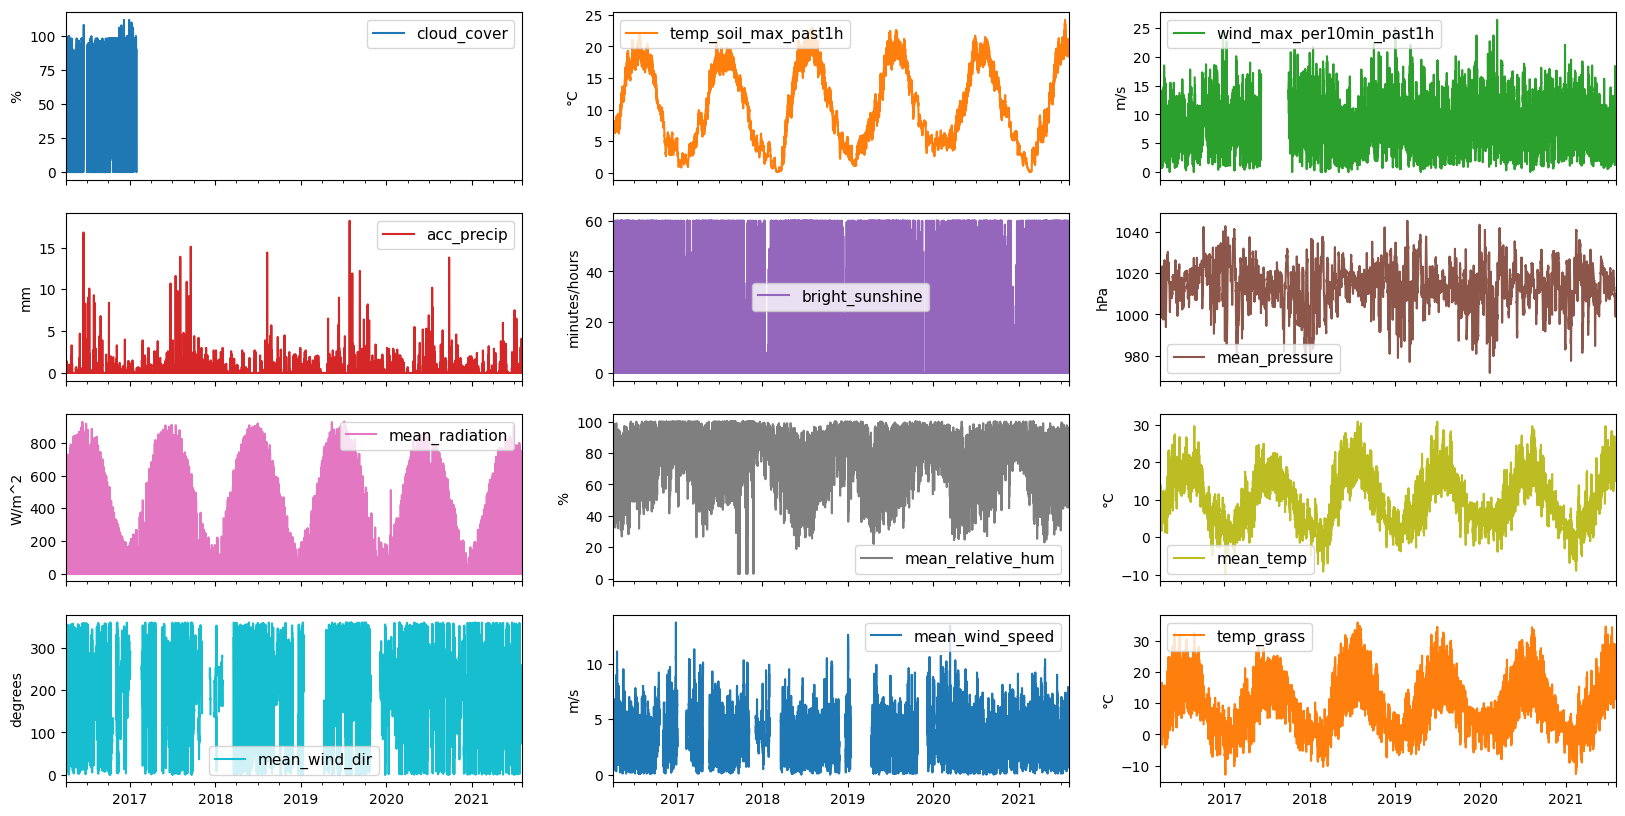

In [127]:
list_of_ylabels_dmi = ['%', '°C', 'm/s', 'mm', 'minutes/hours', 'hPa', 'W/m^2', '%', '°C', 'degrees', 'm/s', '°C']
axs = df_old_dmi[df_old_dmi.columns[2:]].plot(subplots=True, layout=(4,3), figsize = (20,10), sharex=True, xlabel = '');


for ax in range(len(axs.flat)):
    axs.flat[ax].set( ylabel=list_of_ylabels_dmi[ax])

Below is the new approach to gathering DMI data, i.e., filling in all NA's with observations from other stations to combine one DataFrame

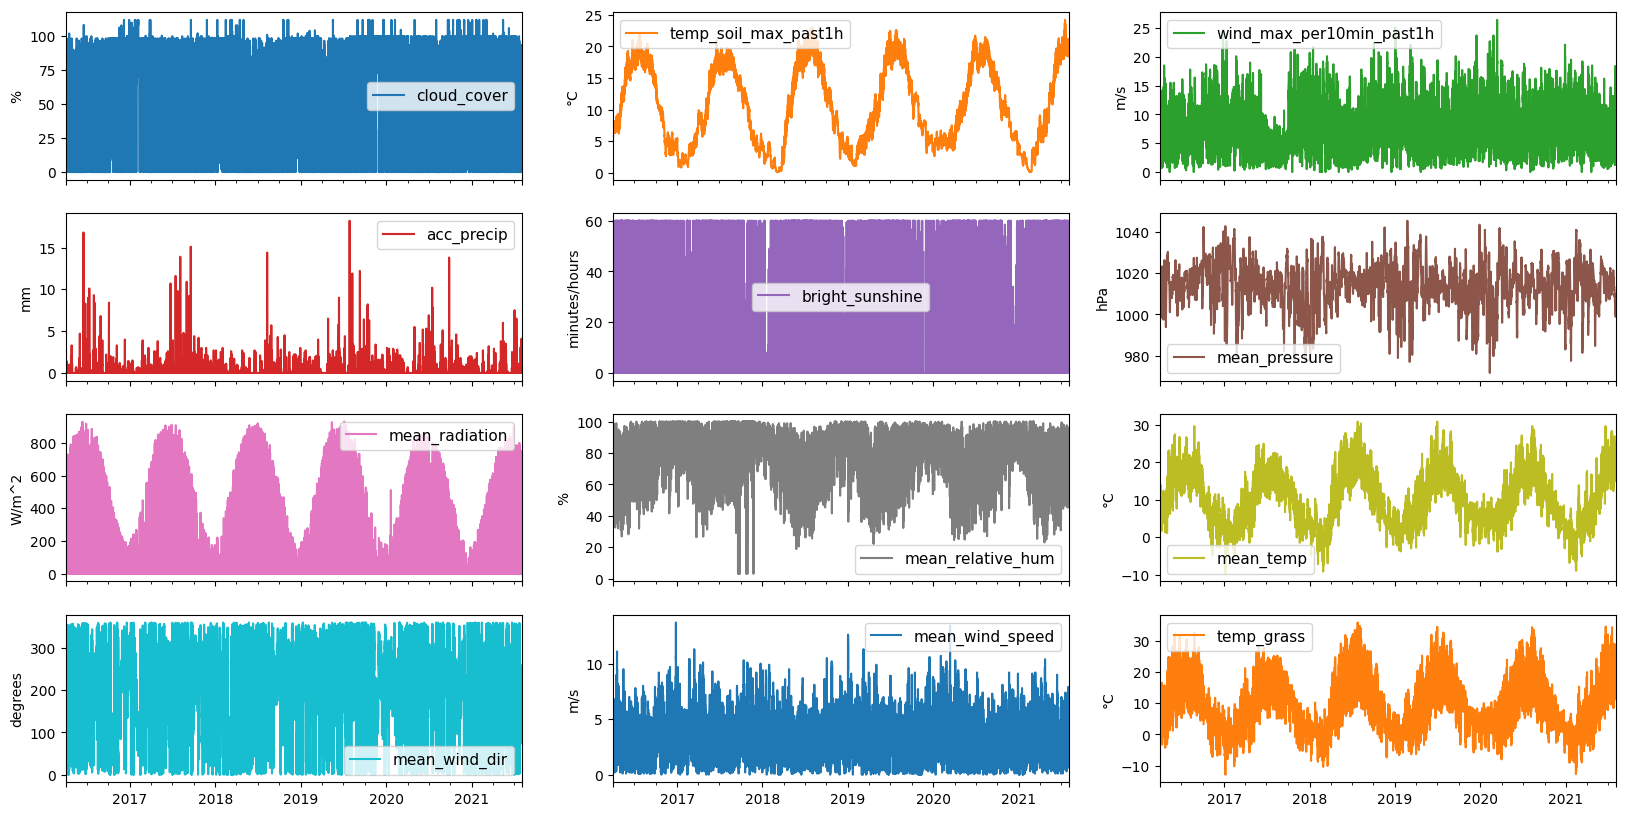

In [128]:
list_of_ylabels_dmi = ['%', '°C', 'm/s', 'mm', 'minutes/hours', 'hPa', 'W/m^2', '%', '°C', 'degrees', 'm/s', '°C']

axs = df_dmi[df_dmi.columns[2:]].plot(subplots=True, layout = (4,3), figsize = (20,10), sharex=True, xlabel = '');
for ax in range(len(axs.flat)):
    axs.flat[ax].set( ylabel=list_of_ylabels_dmi[ax])

In [135]:
for i in df_dmi.columns:
    num_na = len(df_dmi[i]) - len(df_dmi[i].dropna())
    print(f"{i}: {num_na}")

date: 0
hour: 0
cloud_cover: 10
temp_soil_max_past1h: 145
wind_max_per10min_past1h: 49
acc_precip: 8
bright_sunshine: 9
mean_pressure: 8
mean_radiation: 9
mean_relative_hum: 8
mean_temp: 8
mean_wind_dir: 8
mean_wind_speed: 8
temp_grass: 167


The above shows no signs of outliers or unordinary data that causes any concerns. All of the data conforms to the data descriptions on DMI's [API website]("https://confluence.govcloud.dk/display/FDAPI/Danish+Meteorological+Institute+-+Open+Data"). Both the cloud_cover spikes and mean_relative_hum downward spikes appear to merely be extreme observations that are not the result of any measurement errors.

If one looks at the missing data, one will see that the NA's do not appear more consecutively than 2 hours, therefore we've decided to forward fill all of the NA's in the below merging function.

## Nordpool data

In [49]:
df_Nordpool.index = pd.to_datetime(df_Nordpool["date"].apply(str)+' '+pd.to_datetime(df_Nordpool["hour"], format = '%H').dt.time.apply(str))

In [140]:
((df_Nordpool['DK2'].ffill() + df_Nordpool['DK2'].bfill())/2)

False    75840
Name: DK1, dtype: int64

In [50]:
df_Nordpool

date     DK2  hour  DK1_CP  DK2_CP  DK1_PP  DK2_PP  \
2013-01-01 01:00:00 2013-01-01  104.66     1     NaN     NaN  1051.0  1139.0   
2013-01-01 02:00:00 2013-01-01   82.50     2     NaN     NaN   789.0  1123.0   
2013-01-01 03:00:00 2013-01-01   63.41     3     NaN     NaN   735.0  1127.0   
2013-01-01 04:00:00 2013-01-01    0.75     4     NaN     NaN   715.0  1112.0   
2013-01-01 05:00:00 2013-01-01   14.99     5     NaN     NaN   890.0  1104.0   
...                        ...     ...   ...     ...     ...     ...     ...   
2021-08-19 20:00:00 2021-08-19  942.79    20  2623.0  1560.0  1010.0   435.0   
2021-08-19 21:00:00 2021-08-19  952.75    21  2549.0  1517.0   970.0   414.0   
2021-08-19 22:00:00 2021-08-19  889.47    22  2566.0  1519.0   946.0   410.0   
2021-08-19 23:00:00 2021-08-19  818.52    23  2432.0  1401.0   891.0   427.0   
2021-08-19 00:00:00 2021-08-19  743.64     0  2257.0  1287.0   798.0   431.0   

                     DK1_WP  DK2_WP  DK net exchange  ...  DK2 net exchange  \
2013-01-01 01:00:00  1968.0   830.0           -588.0  ...             -16.0   
2013-01-01 02:00:00  1599.0   818.0           -235.0  ...             -65.0   
2013-01-01 03:00:00  1238.0   798.0             45.0  ...             -78.0   
2013-01-01 04:00:00   941.0   765.0            124.0  ...            -111.0   
2013-01-01 05:00:00   709.0   718.0            236.0  ...            -106.0   
...                     ...     ...              ...  ...               ...   
2021-08-19 20:00:00  2248.0   880.0              NaN  ...               NaN   
2021-08-19 21:00:00  1943.0   805.0              NaN  ...               NaN   
2021-08-19 22:00:00  1779.0   758.0              NaN  ...               NaN   
2021-08-19 23:00:00  1784.0   755.0              NaN  ...               NaN   
2021-08-19 00:00:00  1744.0   766.0              NaN  ...               NaN   

                     DK - DE  DK - NO  DK - SE  DK1 - SE3  DK2 - SE4  \
2013-01-01 01:00:00    138.9    -95.4   -102.1       18.5     -120.6   
2013-01-01 02:00:00    168.7    -95.6    -96.4       29.1     -125.5   
2013-01-01 03:00:00    186.8    -95.5    -86.7       40.0     -126.7   
2013-01-01 04:00:00    194.9    -96.3    -85.9       38.3     -124.2   
2013-01-01 05:00:00    198.4    -95.3    -79.4       45.3     -124.7   
...                      ...      ...      ...        ...        ...   
2021-08-19 20:00:00      NaN      NaN      NaN        NaN        NaN   
2021-08-19 21:00:00      NaN      NaN      NaN        NaN        NaN   
2021-08-19 22:00:00      NaN      NaN      NaN        NaN        NaN   
2021-08-19 23:00:00      NaN      NaN      NaN        NaN        NaN   
2021-08-19 00:00:00      NaN      NaN      NaN        NaN        NaN   

                     DK1 - DE  DK2 - DE  DK1 - DK2  DK1 - NL  
2013-01-01 01:00:00      78.9      60.0      -59.0       NaN  
2013-01-01 02:00:00     108.7      60.0      -59.0       NaN  
2013-01-01 03:00:00     126.9      59.9      -59.0       NaN  
2013-01-01 04:00:00     140.8      54.1      -59.0       NaN  
2013-01-01 05:00:00     143.3      55.1      -59.0       NaN  
...                       ...       ...        ...       ...  
2021-08-19 20:00:00       NaN       NaN        NaN       NaN  
2021-08-19 21:00:00       NaN       NaN        NaN       NaN  
2021-08-19 22:00:00       NaN       NaN        NaN       NaN  
2021-08-19 23:00:00       NaN       NaN        NaN       NaN  
2021-08-19 00:00:00       NaN       NaN        NaN       NaN  

[75888 rows x 21 columns]

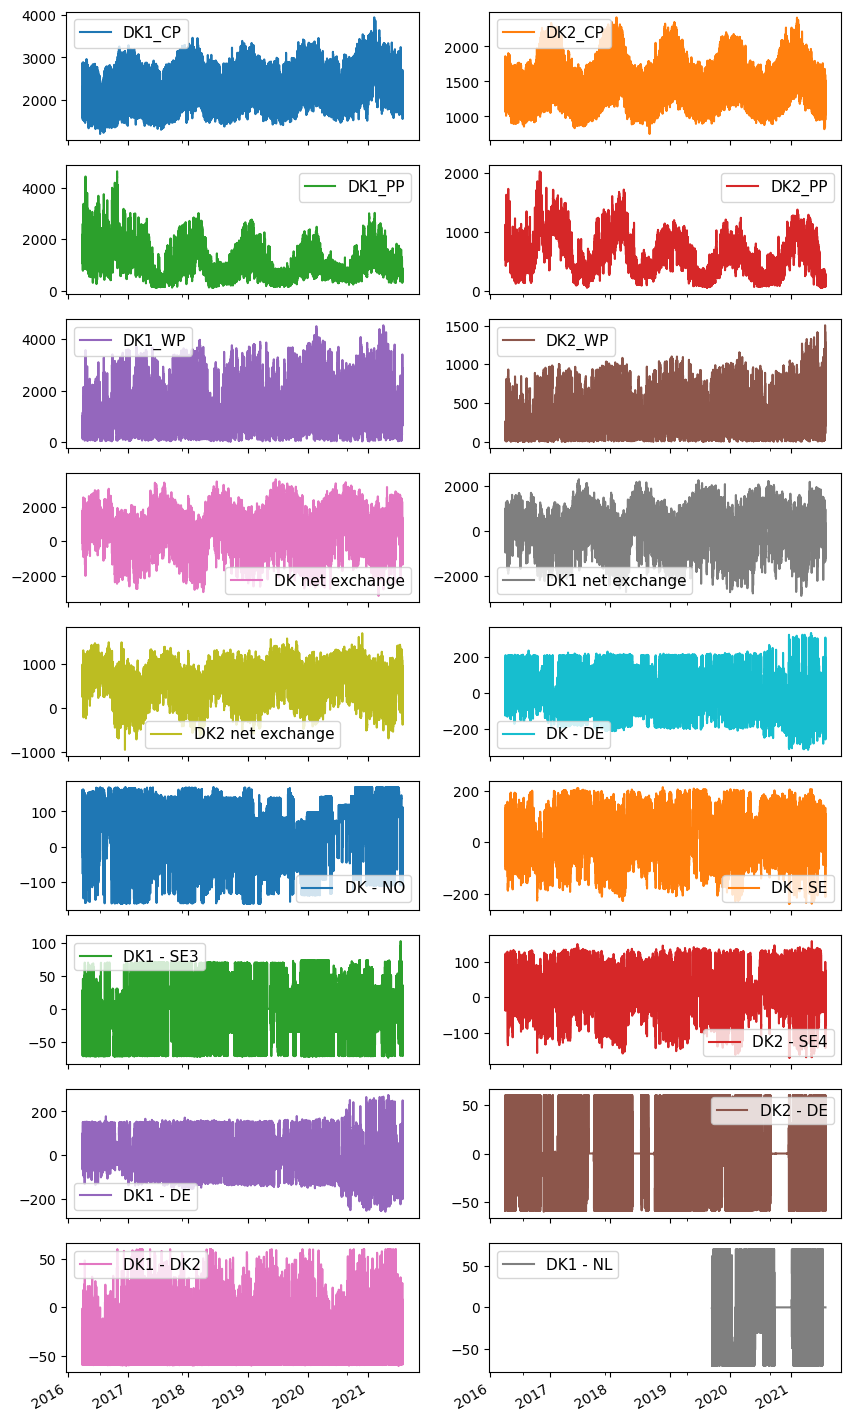

In [100]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('legend',fontsize=11) # using a size in points

# Only plot for the dates that we've collected commodity prices and weather data for
df_Nordpool[df_Nordpool.index.isin(pd.date_range(start = startDate, end = endDate, freq = 'H'))]\
            .drop(['date', 'hour', 'DK2'], axis = 1)\
            .plot(subplots=True, layout = (9,2), figsize = (10,20), sharex=True );

<AxesSubplot:ylabel='Price in DKK per MWh'>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


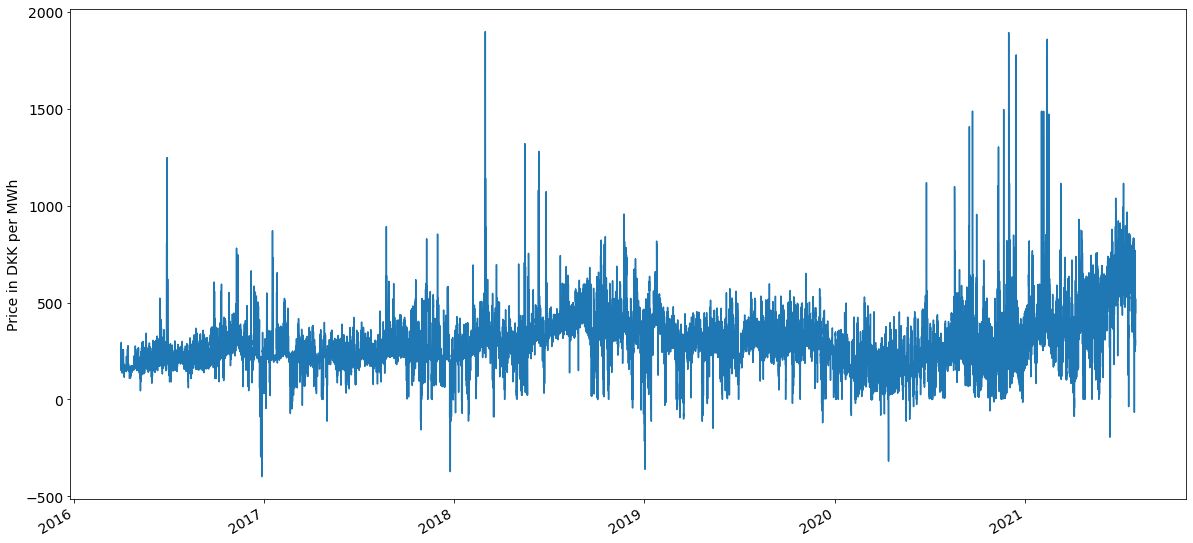

In [64]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

df_Nordpool[df_Nordpool.index.isin(pd.date_range(start = startDate, end = endDate, freq = 'H'))]['DK2'].plot(figsize = (20,10), ylabel = 'Price in DKK per MWh')

In [118]:
for i in df_Nordpool.columns:
    num_na = len(df_Nordpool[df_Nordpool.index.isin(pd.date_range(start = startDate, end = endDate, freq = 'H'))][i]) - len(df_Nordpool[df_Nordpool.index.isin(pd.date_range(start = startDate, end = endDate, freq = 'H'))][i].dropna())
    print(f"{i}: {num_na}")

date: 0
DK1: 4
hour: 0
DK1_CP: 4
DK2_CP: 4
DK1_PP: 4
DK2_PP: 4
DK1_WP: 4
DK2_WP: 4
DK net exchange: 4
DK1 net exchange: 4
DK2 net exchange: 4
DK - DE: 5
DK - NO: 5
DK - SE: 5
DK1 - SE3: 5
DK2 - SE4: 5
DK1 - DE: 5
DK2 - DE: 5
DK1 - DK2: 5
DK1 - NL: 30262


Based on the above figure and no. of NA's, we've decided to remove DK1-NL from our dataset. This is done in the below function that merges all 3 datasources together. 

If one looks at the missing data, one will see that the NA's do not appear more consecutively than 2 hours, therefore we've decided to forward fill all of the NA's in the below merging function.

Other than that we think that the transformation of the dataset is good as is, so we'll leave it until merging.


## Commodity price data

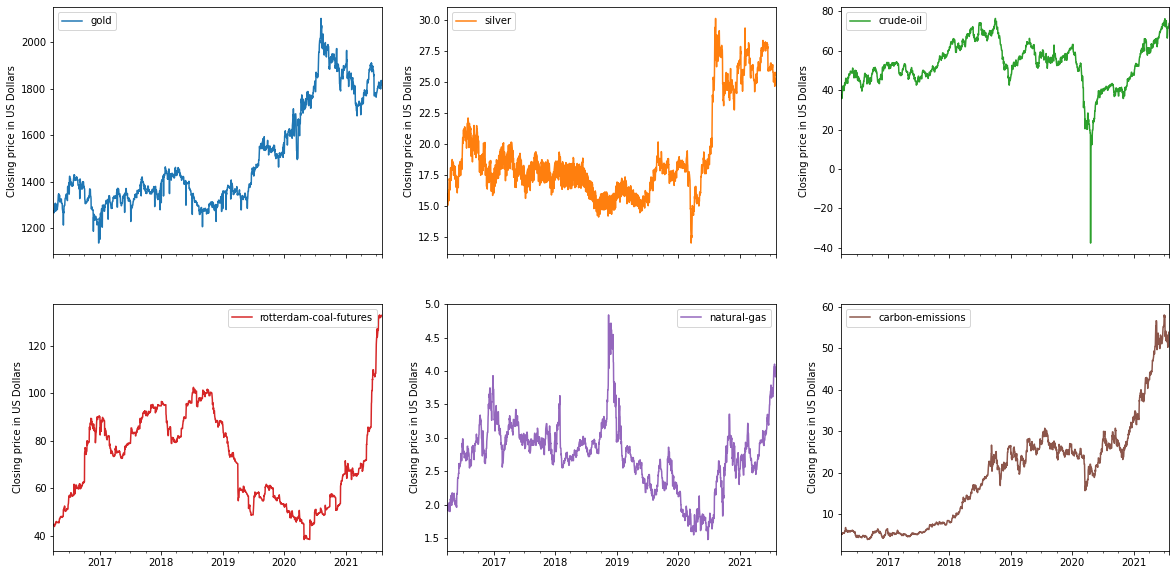

In [46]:
commodities_df.set_index('date').plot(subplots=True, layout = (2,3), figsize = (20,10), sharex=True, xlabel = '', ylabel='Closing price in US Dollars');

In [116]:
for i in commodities_df.columns:
    num_na = len(commodities_df[i]) - len(commodities_df[i].dropna())
    print(f"{i}: {num_na}")

date: 0
gold: 0
silver: 0
crude-oil: 0
rotterdam-coal-futures: 0
natural-gas: 0
carbon-emissions: 0


The above graph shows no signs of mysterious nor unusual data. The commodity data is still only daily observations until the merging happens below. The crude oil drop in start Q2 2020 is of course not a fault of wrong data, however, it was the actual crude oil future price at the time. (https://www.cnbc.com/2020/06/16/how-negative-oil-prices-revealed-the-dangers-of-futures-trading.html)

## The below transforms all of the above dataframes into a single master DataFrame

In [131]:
def total_dataframe(df_nordpool, df_dmi, df_commodities):

    list_of_commodities = ['gold', 'silver', 'crude-oil', 'rotterdam-coal-futures', 'natural-gas', 'carbon-emissions']

    # Below we're merging all of the data together into one DataFrame from all 3 input DF's
    df_nordpool_new = df_nordpool.copy()
    df_nordpool_new['date'] = df_nordpool_new['date'].astype('string')

    df_dmi_new = df_dmi.copy()
    df_dmi_new['date'] = df_dmi_new['date'].astype('string')

    df_commodities_new = df_commodities.copy()
    df_commodities_new['date'] = df_commodities_new['date'].astype('string')

    first_merge = df_dmi_new.merge(df_nordpool_new, on = ['date', 'hour'], how = 'left')
    second_merge = first_merge.merge(df_commodities_new, on = 'date', how = 'left')

    ## Deleting unneeded columns, NaN's, duplicates and dealing with daylight savings.
    # The duplicates were only for changes to wintertime, where there were one duplicate for each year at 3 AM, but with different values
    # for each of the 3 AM observations due to winter time.
    # The mean of those two were taken and are replacing the duplicated hours
    second_merge.drop(['DK1 - NL', 'DK1 - DE', 'DK1 - SE3', 'DK2 - SE4', 'DK2 - DE'], axis = 1, inplace = True)
    new_mean = second_merge[second_merge.duplicated(['date', 'hour'])].groupby(['date', 'hour']).mean().reset_index()
    second_merge.drop_duplicates(['date', 'hour'],  keep = False, inplace = True)
    df_concat = pd.concat([second_merge, new_mean]).sort_values(['date', 'hour']).reset_index(drop = True)

    # We've also replaced the summer time NA's with the mean of the 2nd and 4th hour to create a value for the 3rd hour of the day
    # for all variables except for the commodities, as these does not suffer from this issue, as they're daily observations.
    # They are merely forward filled below.
    list1 = df_concat.columns.tolist()
    list2 = [item for item in list1 if item not in list_of_commodities+['date','hour']]
    for i in list2:
        df_concat[i] = (df_concat[i].ffill() + df_concat[i].bfill())/2

    # Forward fill the commodity data to make the price of all hours of the day equal to the daily price
    df_concat = df_concat.ffill()

    # Below we're generating hour, weekday and month dummies and appending them to the DataFrame 
    # while also converting the index to a Datetime object in the main DataFrame
    df_concat.index = pd.to_datetime(df_concat['date'].apply(str)+' '+pd.to_datetime(df_concat['hour'], format = '%H').dt.time.apply(str))
    df_concat['month'] = df_concat.index.month
    df_concat['weekday'] = df_concat.index.weekday

    d = defaultdict(list)

    d[0] = pd.get_dummies(df_concat['hour'], prefix = 'hour')
    d[1] = pd.get_dummies(df_concat['weekday'], prefix = 'weekday')
    d[2] = pd.get_dummies(df_concat['month'], prefix = 'month')
    df_join = df_concat.copy()
    for i in d.values():
        df_join = df_join.join(i)


    # Below we're lagging the variables to comply with the time series element of our regression
    # as to not create future leakage

    # Lagging the DK2 prices 48 times and only keeping the 24-48 lags
    lagged_DK2 = lagmat(df_join['DK2'], 48, use_pandas = True, trim = 'both')
    lagged_DK2 = lagged_DK2[lagged_DK2.columns[23:]]

    # Lagging the commodity data once by 24 hours
    d_lag_commodity = {}
    for i in list_of_commodities:
        d_lag_commodity[i] = lagmat(df_join[i], 24, use_pandas = True, trim = 'both')
        d_lag_commodity[i] = d_lag_commodity[i][d_lag_commodity[i].columns[23]]
    df_lag_commodity = pd.concat(d_lag_commodity.values(), axis = 1)

    # Lagging the exchange data once
    exchange_list = ['DK net exchange', 'DK1 net exchange', 'DK2 net exchange', 'DK - DE',
       'DK - NO', 'DK - SE', 'DK1 - DK2']
    d_lag_exchange = {}
    for i in exchange_list:
        d_lag_exchange[i] = lagmat(df_join[i], 24, use_pandas = True, trim = 'both')
        d_lag_exchange[i] = d_lag_exchange[i][d_lag_exchange[i].columns[23]]
    df_lag_exchange = pd.concat(d_lag_exchange.values(), axis = 1)

    # Appending all lags to the DataFrame
    list_of_df_lags = [df_lag_commodity, df_lag_exchange, lagged_DK2]
    for i in list_of_df_lags:
        df_join = df_join.join(i)
    
    # Dropping original non-lagged columns except the target, DK2
    df_join = df_join.dropna().drop(exchange_list+list_of_commodities+['month', 'weekday', 'date', 'hour'], axis = 1)
    df_join.drop(['weekday_0', 'hour_0', 'month_1'], axis = 1, inplace = True)

    # Adding a trend column to detrend
    df_join['trend'] = [i+1 for i in range(len(df_join))]

    return df_join

In [132]:
df_all_data = total_dataframe(df_Nordpool, df_dmi, commodities_df)

In [140]:
df_all_data

cloud_cover  temp_soil_max_past1h  \
2016-04-03 00:00:00     5.000000                   6.8   
2016-04-03 01:00:00    41.666667                   6.7   
2016-04-03 02:00:00    38.333333                   6.6   
2016-04-03 03:00:00    36.666667                   6.5   
2016-04-03 04:00:00    96.666667                   6.5   
...                          ...                   ...   
2021-07-31 20:00:00    37.500000                  19.7   
2021-07-31 21:00:00    70.833333                  19.6   
2021-07-31 22:00:00    72.500000                  19.6   
2021-07-31 23:00:00    78.333333                  19.5   
2021-08-01 00:00:00    90.000000                  19.4   

                     wind_max_per10min_past1h  acc_precip  bright_sunshine  \
2016-04-03 00:00:00                       8.1         0.0              0.0   
2016-04-03 01:00:00                       7.8         0.0              0.0   
2016-04-03 02:00:00                       7.4         0.0              0.0   
2016-04-03 03:00:00                       5.2         0.0              0.0   
2016-04-03 04:00:00                       5.2         0.0              0.0   
...                                       ...         ...              ...   
2021-07-31 20:00:00                      10.5         0.2              4.0   
2021-07-31 21:00:00                      12.0         0.0             33.5   
2021-07-31 22:00:00                      12.4         4.1              0.0   
2021-07-31 23:00:00                      12.1         0.2              0.0   
2021-08-01 00:00:00                      13.1         0.0              0.0   

                     mean_pressure  mean_radiation  mean_relative_hum  \
2016-04-03 00:00:00         1017.7             0.0               64.5   
2016-04-03 01:00:00         1017.3             0.0               74.3   
2016-04-03 02:00:00         1017.3             0.0               84.5   
2016-04-03 03:00:00         1016.7             0.0               86.5   
2016-04-03 04:00:00         1016.6             0.0               87.7   
...                            ...             ...                ...   
2021-07-31 20:00:00          998.9            56.0               96.0   
2021-07-31 21:00:00          999.3            45.0               95.0   
2021-07-31 22:00:00         1000.1             2.0               96.2   
2021-07-31 23:00:00         1000.7             0.0               96.0   
2021-08-01 00:00:00         1001.3             0.0               91.5   

                     mean_temp  mean_wind_dir  ...  DK2.L.40  DK2.L.41  \
2016-04-03 00:00:00        7.5          102.0  ...    248.03    164.36   
2016-04-03 01:00:00        6.1          104.7  ...    294.07    248.03   
2016-04-03 02:00:00        5.0          109.8  ...    279.17    294.07   
2016-04-03 03:00:00        4.8           95.5  ...    251.38    279.17   
2016-04-03 04:00:00        4.8          106.8  ...    222.17    251.38   
...                        ...            ...  ...       ...       ...   
2021-07-31 20:00:00       15.4          240.0  ...    348.52    358.85   
2021-07-31 21:00:00       15.6          242.0  ...    343.68    348.52   
2021-07-31 22:00:00       15.2          233.0  ...    346.95    343.68   
2021-07-31 23:00:00       15.3          248.0  ...    372.84    346.95   
2021-08-01 00:00:00       15.0          246.0  ...    391.28    372.84   

                     DK2.L.42  DK2.L.43  DK2.L.44  DK2.L.45  DK2.L.46  \
2016-04-03 00:00:00    158.40    153.63    150.05    151.54    151.32   
2016-04-03 01:00:00    164.36    158.40    153.63    150.05    151.54   
2016-04-03 02:00:00    248.03    164.36    158.40    153.63    150.05   
2016-04-03 03:00:00    294.07    248.03    164.36    158.40    153.63   
2016-04-03 04:00:00    279.17    294.07    248.03    164.36    158.40   
...                       ...       ...       ...       ...       ...   
2021-07-31 20:00:00    370.46    359.60    517.79    443.72    416.87   
2021-07-31 21:00:00    358.85    370.

In [269]:
# Below we're merging all of the data together into one DataFrame from all 3 input DF's
df_nordpool_new = df_Nordpool.copy()
df_nordpool_new['date'] = df_nordpool_new['date'].astype('string')
 
df_dmi_new = df_dmi.copy()
df_dmi_new['date'] = df_dmi_new['date'].astype('string')

df_commodities_new = commodities_df.copy()
df_commodities_new['date'] = df_commodities_new['date'].astype('string')

first_merge = df_dmi_new.merge(df_nordpool_new, on = ['date', 'hour'], how = 'left')
second_merge = first_merge.merge(df_commodities_new, on = 'date', how = 'left')

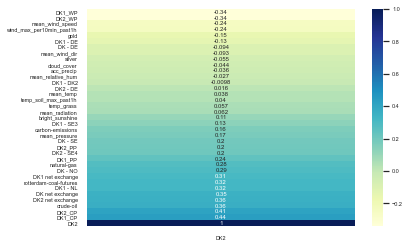

In [297]:
cols = second_merge.columns[2:]

#cm = np.corrcoef(second_merge[cols].values.T)
sns.set(font_scale=0.5)

hm = sns.heatmap(pd.DataFrame(second_merge[cols].corr()['DK2']).sort_values(by = 'DK2'), cmap = 'YlGnBu', annot = True)
plt.show()